# Simple neural network

Tutorial:
https://andrew.carterlunn.co.uk/programming/2018/02/20/beating-the-bookmakers-with-tensorflow.html

In [ ]:
# runs the neural network training, and the betting analysis. Output file is training-log.csv
%run predict.py

In [56]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import dataset
import betting
import csv

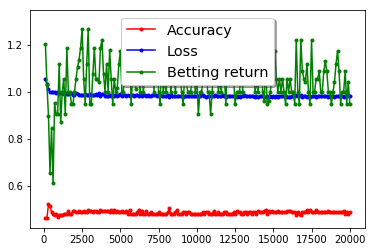

In [3]:
x,a, b, c = np.loadtxt('training-log.csv', delimiter=',', unpack=True)

# red dashes, blue squares and green triangles
plt.plot(x, a, '.r-', x, b, '.b-', x, c, '.g-')

plt.legend(('Accuracy', 'Loss','Betting return'), loc='upper center', shadow=True, fontsize='x-large')

plt.show()

## Restore model from checkpoint

In [48]:
TRAINING_SET_FRACTION = 0.95

data = dataset.Dataset('data/book.csv')

train_results_len = int(TRAINING_SET_FRACTION * len(data.processed_results))
train_results = data.processed_results[:train_results_len]
test_results = data.processed_results[train_results_len:]

def map_results(results):
    features = {}

    for result in results:
        for key in result.keys():
            if key not in features:
                features[key] = []

            features[key].append(result[key])

    for key in features.keys():
        features[key] = np.array(features[key])

    return features, features['result']

train_features, train_labels = map_results(train_results)
test_features, test_labels = map_results(test_results)

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=train_features,
    y=train_labels,
    batch_size=500,
    num_epochs=None,
    shuffle=True
)

test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=test_features,
    y=test_labels,
    num_epochs=1,
    shuffle=False
)

feature_columns = []

for mode in ['home', 'away']:
    feature_columns = feature_columns + [
        tf.feature_column.numeric_column(key='{}-wins'.format(mode)),
        tf.feature_column.numeric_column(key='{}-draws'.format(mode)),
        tf.feature_column.numeric_column(key='{}-losses'.format(mode)),
        tf.feature_column.numeric_column(key='{}-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-goals'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-shots-on-target'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots'.format(mode)),
        tf.feature_column.numeric_column(key='{}-opposition-shots-on-target'.format(mode)),
    ]

In [49]:
model = tf.estimator.DNNClassifier(
    model_dir='model/',
    hidden_units=[10],
    feature_columns=feature_columns,
    n_classes=3,
    label_vocabulary=['H', 'D', 'A'],
    optimizer=tf.train.ProximalAdagradOptimizer(
        learning_rate=0.1,
        l1_regularization_strength=0.001
    ))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015B022CA278>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [50]:
# What is the latest checkpoint?
model.latest_checkpoint()

'model/model.ckpt-20000'

In [51]:
evaluation_result = model.evaluate(input_fn=test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-01-04-11:53:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-01-04-11:53:18
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.4883721, average_loss = 0.9819084, global_step = 20000, loss = 84.44412
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 20000: model/model.ckpt-20000


In [52]:
predictions = list(model.predict(input_fn=test_input_fn))
prediction_result = betting.test_betting_stategy(predictions, test_features, test_labels)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [66]:
#evaluation_result
predictions

[{'logits': array([-16.091715, -16.79451 , -17.004255], dtype=float32),
  'probabilities': array([0.5272309 , 0.26108435, 0.21168476], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'H'], dtype=object)},
 {'logits': array([-4.3641114, -4.207876 , -3.606466 ], dtype=float32),
  'probabilities': array([0.2324312 , 0.27173558, 0.49583325], dtype=float32),
  'class_ids': array([2], dtype=int64),
  'classes': array([b'A'], dtype=object)},
 {'logits': array([-13.344783 , -13.846368 , -13.8661175], dtype=float32),
  'probabilities': array([0.4546906 , 0.27534702, 0.26996237], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'H'], dtype=object)},
 {'logits': array([-20.998373, -22.060572, -22.609692], dtype=float32),
  'probabilities': array([0.6471155 , 0.22370453, 0.12917992], dtype=float32),
  'class_ids': array([0], dtype=int64),
  'classes': array([b'H'], dtype=object)},
 {'logits': array([-19.620354, -20.581615, -21.035423], dtype

In [60]:
train_features

{'result': array(['H', 'D', 'A', ..., 'H', 'A', 'A'], dtype='<U1'),
 'odds-home': array([ 1.17,  2.  ,  1.91, ...,  2.14,  2.04, 11.  ]),
 'odds-draw': array([6.5 , 3.3 , 3.4 , ..., 3.39, 3.6 , 6.5 ]),
 'odds-away': array([21.  ,  4.  ,  4.2 , ...,  3.79,  3.79,  1.28]),
 'home-wins': array([7, 4, 4, ..., 7, 4, 2]),
 'home-draws': array([2, 1, 2, ..., 2, 3, 4]),
 'home-losses': array([1, 5, 4, ..., 1, 3, 4]),
 'home-goals': array([22, 10, 10, ..., 24, 15,  8]),
 'home-opposition-goals': array([ 4, 15, 15, ...,  4, 22, 12]),
 'home-shots': array([178, 110, 120, ..., 146, 111,  96]),
 'home-shots-on-target': array([92, 64, 68, ..., 53, 32, 28]),
 'home-opposition-shots': array([ 92, 151, 130, ...,  93, 130, 140]),
 'home-opposition-shots-on-target': array([52, 83, 69, ..., 28, 50, 31]),
 'away-wins': array([3, 4, 2, ..., 7, 3, 9]),
 'away-draws': array([3, 0, 2, ..., 2, 2, 1]),
 'away-losses': array([4, 6, 6, ..., 1, 5, 0]),
 'away-goals': array([ 9, 14, 11, ..., 26, 11, 37]),
 'away-opp

In [59]:
train_labels

array(['H', 'D', 'A', ..., 'H', 'A', 'A'], dtype='<U1')

In [64]:
feature_columns[0]

_NumericColumn(key='home-wins', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)